<a href="https://colab.research.google.com/github/sri-py/neuralnet_energydata/blob/main/Final_Code_Network_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import datetime
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_predict, KFold

Uploading files to Colab environment needed for making a neural network.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving belpex_2011.csv to belpex_2011.csv
Saving belpex_20162017.csv to belpex_20162017.csv
Saving solar_20162017.csv to solar_20162017.csv
Saving wind_20162017.csv to wind_20162017.csv


Reading the Dataset:
In this, we will be working on formatting the Data to fit all the different datasets into one time series frame.

In [ ]:
start_date = dt.datetime(2016,1,1)
end_date = dt.datetime(2017, 12, 31)

#solar data selection
df_solar = pd.read_csv('solar_20162017.csv', header=0)
df_solar = df_solar.rename(columns = {'Unnamed: 0':'time'})
df_solar['time'] = pd.to_datetime(df_solar['time'])
df_solar.set_index('time', inplace=True)
df_solar = df_solar.DayAheadForecast

df_solar_load = pd.read_csv('solar_20162017.csv', header=0)
df_solar_load = df_solar_load.rename(columns = {'Unnamed: 0':'time'})
df_solar_load['time'] = pd.to_datetime(df_solar_load['time'])
df_solar_load.set_index('time', inplace=True)
df_solar_load = df_solar_load.LoadFactor

# wind data selection
df_wind = pd.read_csv('wind_20162017.csv', header=0)
df_wind = df_wind.rename(columns = {'Unnamed: 0':'time'})
df_wind['time'] = pd.to_datetime(df_wind['time'])
df_wind.set_index('time', inplace=True)
df_wind = df_wind.DayAheadForecast
df_wind.head()

df_wind_load = pd.read_csv('wind_20162017.csv', header=0)
df_wind_load = df_wind_load.rename(columns = {'Unnamed: 0':'time'})
df_wind_load['time'] = pd.to_datetime(df_wind_load['time'])
df_wind_load.set_index('time', inplace=True)
df_wind_load = df_wind_load.LoadFactor
df_wind_load.head()

#belpex price values
df_belpex = pd.read_csv('belpex_20162017.csv', header=0)
df_belpex = df_belpex.rename(columns = {'Unnamed: 0':'time'})
df_belpex['time'] = pd.to_datetime(df_belpex['time'])
df_belpex.set_index('time', inplace=True)



In [ ]:
#making belpex from 1 hr to 15 mins timeframe
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p = df_belpex.loc[d]
    except KeyError:
        df_belpex.loc[d] = df_belpex.loc[d-dt.timedelta(hours=1)]
df_belpex = df_belpex.sort_index()
df_belpex = df_belpex[start_date:end_date]

#removing empty values in wind and solar data
df_wind =  df_wind.fillna(method='pad')
df_wind_load =  df_wind_load.fillna(method='pad')

df_solar =  df_solar.fillna(method='pad')
df_solar_load =  df_solar_load.fillna(method='pad')
#belpex to 15 mins time frame 
df_belpex = df_belpex.resample('15T').pad()

#formulating the whole data table now
d = {'belpex': df_belpex.values.flatten(), 'solar': df_solar.values, 'wind': df_wind.values, 'solar_load': df_solar_load.values, 'wind_load': df_wind_load.values}
data = pd.DataFrame(index=df_belpex.index, data=d)

data.head()

,belpex,solar,wind,solar_load,wind_load
time,,,,,
2016-01-01 00:00:00,23.86,0.0,1146.36,0.0,0.47
2016-01-01 00:15:00,23.86,0.0,1104.56,0.0,0.43
2016-01-01 00:30:00,23.86,0.0,1062.74,0.0,0.41
2016-01-01 00:45:00,23.86,0.0,1020.93,0.0,0.41
2016-01-01 01:00:00,22.39,0.0,973.72,0.0,0.40


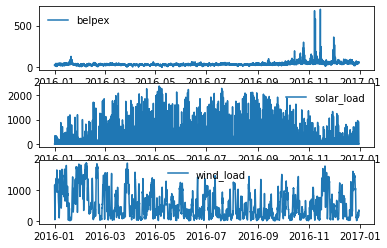

In [ ]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 12, 30, 23, 45)

plt.figure()
plt.subplot(311)
plt.plot(data.belpex[start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data.solar[start:end], label='solar_load')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data.wind[start:end], label='wind_load')
plt.legend(frameon=False)
plt.show()

Removing the outliers in the data

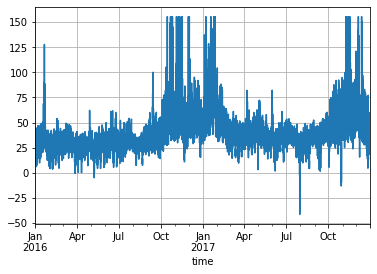

In [ ]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 5
data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std 
data['belpex'][(data.belpex <= mean - n_std*std)] = mean + n_std*std 

def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)

plt.figure()
data.belpex.plot(grid=True)
plt.show()

# Starting with Neural Network

First, we perform the consturction of datasets(training, validation, target)

# 1.Training Dataset

In [ ]:
n_hours = 24
start_X = datetime.datetime(2017, 1, 1, 0, 0)
end_X = datetime.datetime(2017, 12, 29, 23, 45)

start_Y = datetime.datetime(2017, 1, 2, 0, 0)
end_Y = datetime.datetime(2017, 12, 30, 23, 45)

start_shift = datetime.datetime(2016, 12, 26, 0, 0)
end_shift = datetime.datetime(2017, 12, 23, 23, 45)

X = data['belpex'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)
X_shift = data['belpex'][start_shift:end_shift].resample('1H').mean().values.reshape(-1, n_hours)
S = data['solar'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)
W = data['wind'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)
S_load = data['solar_load'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)
W_load = data['wind_load'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)

rows = X.shape[0]
col = X.shape[1]
T = np.zeros((rows,6*col))

for i in range(0,rows):
    T[i,0:col] = X[i,0:col]
    T[i,col:2*col] = S[i,0:col]
    T[i,2*col:3*col] = W[i,0:col]
    T[i,3*col:4*col] = X_shift[i,0:col]
    T[i,4*col:5*col] = S_load[i,0:col]
    T[i,5*col:6*col] = W_load[i,0:col]

Y = data['belpex'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)

print(Y)


[[42.79 39.66 39.2  ... 54.72 51.12 51.46]
 [52.48 44.75 45.23 ... 48.9  68.73 65.  ]
 [39.   42.7  40.   ... 49.88 47.61 48.94]
 ...
 [31.16 30.   28.1  ... 40.58 38.23 34.08]
 [34.08 35.77 43.77 ... 37.59 37.99 40.66]
 [23.1  23.37 22.55 ... 23.31 24.34 23.49]]


# 2.Validation Set

In [ ]:
n_hours = 24

start_X = datetime.datetime(2016, 1, 8, 0, 0)
end_X = datetime.datetime(2017, 1, 5, 23, 45)

start_Y = datetime.datetime(2016, 1, 9, 0, 0)
end_Y = datetime.datetime(2017, 1, 6, 23, 45)

start_shift = datetime.datetime(2016, 1, 2, 0, 0)
end_shift = datetime.datetime(2016, 12, 30, 23, 45)

X = data['belpex'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)
X_shift = data['belpex'][start_shift:end_shift].resample('1H').mean().values.reshape(-1, n_hours)
S = data['solar'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)
W = data['wind'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)
S_load = data['solar_load'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)
W_load = data['wind_load'][start_X:end_X].resample('1H').mean().values.reshape(-1, n_hours)

rows = X.shape[0]
col = X.shape[1]
T_val = np.zeros((rows,6*col))

for i in range(0,rows):
    T_val[i,0:col] = X[i,0:col]
    T_val[i,col:2*col] = S[i,0:col]
    T_val[i,2*col:3*col] = W[i,0:col]
    T_val[i,3*col:4*col] = X_shift[i,0:col]
    T_val[i,4*col:5*col] = S_load[i,0:col]
    T_val[i,5*col:6*col] = W_load[i,0:col]
    
Y_val = data['belpex'][start_Y:end_Y].resample('1H').mean().values.reshape(-1, n_hours)

print(Y_val)

[[ 26.1   25.1   24.3  ...  25.01  25.1   22.28]
 [ 15.58  19.05  17.01 ...  27.44  26.93  23.12]
 [ 21.95  20.04  19.78 ...  30.09  32.89  27.65]
 ...
 [ 39.    42.7   40.   ...  49.88  47.61  48.94]
 [ 42.7   36.32  40.85 ...  56.47  52.78  53.73]
 [ 52.65  45.19  43.34 ...  75.61  76.22 101.74]]


# 3.Traing the Neural Network

In [ ]:
import os

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, SGD

from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
neurons = [144 ,100,24]
activation_functions = ['relu','relu','linear']

model = Sequential()
model.add(Dense(neurons[0], input_dim=T.shape[1], activation=activation_functions[0]))
model.add(Dense(neurons[1], activation=activation_functions[1]))
model.add(Dense(neurons[2], activation=activation_functions[2]))

rprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)

output_training = model.fit(T, Y, epochs=750, batch_size=32, verbose=0, validation_data=(T_val,Y_val))
mse = output_training.history['loss'][-1]
print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

- mse is 58.3307 @ 750


- mse is 43.4288 @ 254


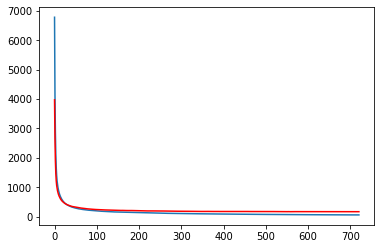

In [ ]:
ww = model.get_weights()

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

mean_window=30
train_loss = plt.plot(running_mean(x=output_training.history['loss'], N=mean_window), label='training error')
val_loss = plt.plot(running_mean(x=output_training.history['val_loss'], N=mean_window), color='red', label='validation error')

ea = EarlyStopping(monitor='val_loss', patience=100)

output_training = model.fit(T, Y, epochs=750, batch_size=32, verbose=0, validation_data=(T_val,Y_val), callbacks=[ea])
mse = output_training.history['loss'][-1]
print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))

0.11615916345992858


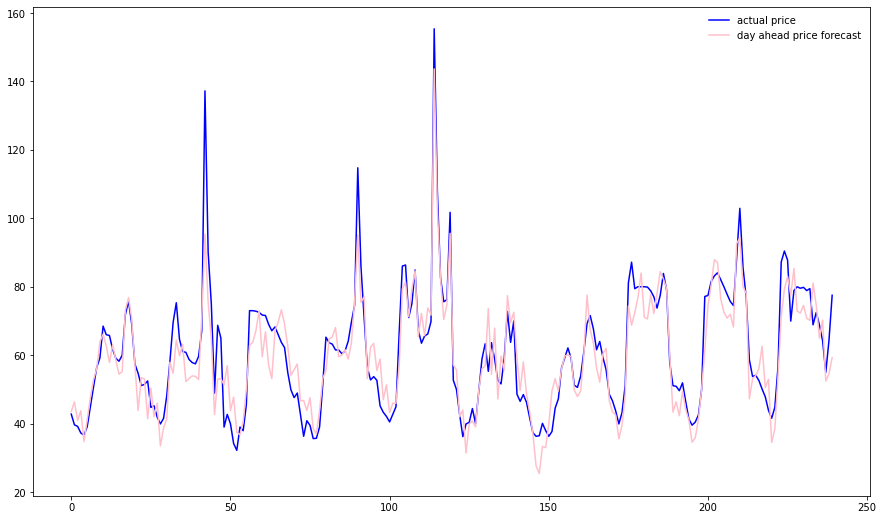

In [ ]:
predict_nn = model.predict(T)

print(get_accuracy(Y.flatten(), predict_nn.flatten()))

# Plots
plt.figure(figsize=(15, 9))
plt.plot(Y[:10,:].flatten(), color='blue', label='actual price')
plt.plot(predict_nn[:10,:].flatten(), color='pink', label='day ahead price forecast')
plt.legend(frameon=False)
plt.show()

# Using the Evaluation Set

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving belpex_week_1.csv to belpex_week_1.csv
Saving belpex_week_2.csv to belpex_week_2.csv
Saving belpex_week_3.csv to belpex_week_3.csv
Saving solar_week_1.csv to solar_week_1.csv
Saving solar_week_2.csv to solar_week_2.csv
Saving solar_week_3.csv to solar_week_3.csv
Saving wind_week_1.csv to wind_week_1.csv
Saving wind_week_2.csv to wind_week_2.csv
Saving wind_week_3.csv to wind_week_3.csv


Week 1

         0
0    37.53
1    33.98
2    32.60
3    26.99
4    27.85
..     ...
163  50.70
164  46.03
165  53.50
166  48.01
167  41.60

[168 rows x 1 columns]


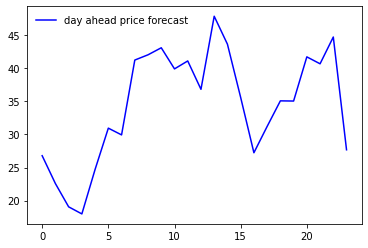

In [ ]:
#Loading solar values
df_solar = pd.read_csv('solar_week_1.csv', header=0)
df_solar = df_solar.DayAheadForecast

df_solar_load = pd.read_csv('solar_week_1.csv', header=0)
df_solar_load = df_solar_load.LoadFactor

#EXCLUDING NAN VALUES FROM SOLAR DATASET 
df_solar =  df_solar.fillna(method='pad')
df_solar_load =  df_solar_load.fillna(method='pad')

i = int(len(df_solar)/4)
solar = np.zeros((i))

for r in range(0,i):
    solar[r] = (df_solar[r*4]+df_solar[r*4+1]+df_solar[r*4+2]+df_solar[r*4+3])/4

i = int(len(df_solar_load)/4)
solar_load = np.zeros((i))

for r in range(0,i):
    solar_load[r] = (df_solar_load[r*4]+df_solar_load[r*4+1]+df_solar_load[r*4+2]+df_solar_load[r*4+3])/4
    
solar_load = solar_load[:len(solar_load)-24]

#Loading wind values
df_wind = pd.read_csv('wind_week_1.csv', header=0)
df_wind = df_wind.DayAheadForecast

df_wind_load = pd.read_csv('wind_week_1.csv', header=0)
df_wind_load = df_wind_load.LoadFactor

#EXCLUDING NAN VALUES FROM SOLAR DATASET 
df_wind =  df_wind.fillna(method='pad')
df_wind_load =  df_wind_load.fillna(method='pad')

i = int(len(df_wind)/4)
wind = np.zeros((i))

for r in range(0,i):
    wind[r] = (df_wind[r*4]+df_wind[r*4+1]+df_wind[r*4+2]+df_wind[r*4+3])/4

i = int(len(df_wind_load)/4)
wind_load = np.zeros((i))

for r in range(0,i):
    wind_load[r] = (df_wind_load[r*4]+df_wind_load[r*4+1]+df_wind_load[r*4+2]+df_wind_load[r*4+3])/4

wind_load = wind_load[:len(wind_load)-24]

#Loading prices 
df_belpex = pd.read_csv('belpex_week_1.csv', header=0)
print(df_belpex)
df_belpex = df_belpex.rename(columns = {'0':'price'}) #I added that, rename 
df_belpex = df_belpex.price
df_belpex = df_belpex.fillna(method='pad')

#Data matrix
D = np.zeros((1,144))
p = len(wind)
q = len(df_belpex)

D[0,0:24] = df_belpex[q-24:q]
D[0,24:2*24] = solar[p-24:p]
D[0,2*24:3*24] = wind[p-24:p]
D[0,3*24:4*24] = df_belpex[0:24]
D[0,4*24:5*24] = solar_load[q-24:q]
D[0,5*24:6*24] = wind_load[q-24:q]

#Predict prices
A = model.predict(D)

plt.figure()
plt.plot(A.flatten(), color='blue', label='day ahead price forecast')
plt.legend(frameon=False)
plt.show()



Week 2

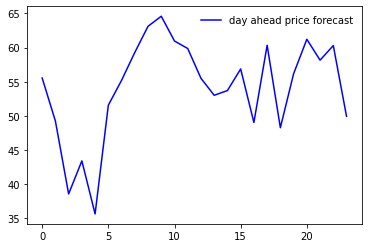

In [ ]:
df_solar = pd.read_csv('solar_week_2.csv', header=0)
df_solar = df_solar.DayAheadForecast

df_solar_load = pd.read_csv('solar_week_2.csv', header=0)
df_solar_load = df_solar_load.LoadFactor

#Overschrijven van lege waarden in de wind voorspellingen
df_solar =  df_solar.fillna(method='pad')
df_solar_load =  df_solar_load.fillna(method='pad')

i = int(len(df_solar)/4)
solar = np.zeros((i))

for r in range(0,i):
    solar[r] = (df_solar[r*4]+df_solar[r*4+1]+df_solar[r*4+2]+df_solar[r*4+3])/4

i = int(len(df_solar_load)/4)
solar_load = np.zeros((i))

for r in range(0,i):
    solar_load[r] = (df_solar_load[r*4]+df_solar_load[r*4+1]+df_solar_load[r*4+2]+df_solar_load[r*4+3])/4
    
solar_load = solar_load[:len(solar_load)-24]

#Inlezen wind waarden
df_wind = pd.read_csv('wind_week_2.csv', header=0)
df_wind = df_wind.DayAheadForecast

df_wind_load = pd.read_csv('wind_week_2.csv', header=0)
df_wind_load = df_wind_load.LoadFactor

#Overschrijven van lege waarden in de wind voorspellingen
df_wind =  df_wind.fillna(method='pad')
df_wind_load =  df_wind_load.fillna(method='pad')

i = int(len(df_wind)/4)
wind = np.zeros((i))

for r in range(0,i):
    wind[r] = (df_wind[r*4]+df_wind[r*4+1]+df_wind[r*4+2]+df_wind[r*4+3])/4
    
i = int(len(df_wind_load)/4)
wind_load = np.zeros((i))

for r in range(0,i):
    wind_load[r] = (df_wind_load[r*4]+df_wind_load[r*4+1]+df_wind_load[r*4+2]+df_wind_load[r*4+3])/4

wind_load = wind_load[:len(wind_load)-24]

#Inlezen prijzen
df_belpex = pd.read_csv('belpex_week_2.csv', header=0)
df_belpex = df_belpex.rename(columns = {'0':'price'}) #I added that, rename 
df_belpex = df_belpex.price
df_belpex = df_belpex.fillna(method='pad')

D = np.zeros((1,144))
p = len(wind)
q = len(df_belpex)

D[0,0:24] = df_belpex[q-24:q]
D[0,24:2*24] = solar[p-24:p]
D[0,2*24:3*24] = wind[p-24:p]
D[0,3*24:4*24] = df_belpex[0:24]
D[0,4*24:5*24] = solar_load[q-24:q]
D[0,5*24:6*24] = wind_load[q-24:q]

B = model.predict(D)

plt.figure()
plt.plot(B.flatten(), color='blue', label='day ahead price forecast')
plt.legend(frameon=False)
plt.show()

Week 3

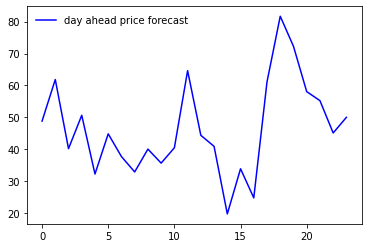

In [ ]:
df_solar = pd.read_csv('solar_week_3.csv', header=0)
df_solar = df_solar.DayAheadForecast

df_solar_load = pd.read_csv('solar_week_3.csv', header=0)
df_solar_load = df_solar_load.LoadFactor

#Overschrijven van lege waarden in de wind voorspellingen
df_solar =  df_solar.fillna(method='pad')
df_solar_load =  df_solar_load.fillna(method='pad')

i = int(len(df_solar)/4)
solar = np.zeros((i))

for r in range(0,i):
    solar[r] = (df_solar[r*4]+df_solar[r*4+1]+df_solar[r*4+2]+df_solar[r*4+3])/4

i = int(len(df_solar_load)/4)
solar_load = np.zeros((i))

for r in range(0,i):
    solar_load[r] = (df_solar_load[r*4]+df_solar_load[r*4+1]+df_solar_load[r*4+2]+df_solar_load[r*4+3])/4
    
solar_load = solar_load[:len(solar_load)-24]

#Inlezen wind waarden
df_wind = pd.read_csv('wind_week_3.csv', header=0)
df_wind = df_wind.DayAheadForecast

df_wind_load = pd.read_csv('wind_week_3.csv', header=0)
df_wind_load = df_wind_load.LoadFactor

#Overschrijven van lege waarden in de wind voorspellingen
df_wind =  df_wind.fillna(method='pad')
df_wind_load =  df_wind_load.fillna(method='pad')

i = int(len(df_wind)/4)
wind = np.zeros((i))

for r in range(0,i):
    wind[r] = (df_wind[r*4]+df_wind[r*4+1]+df_wind[r*4+2]+df_wind[r*4+3])/4

i = int(len(df_wind_load)/4)
wind_load = np.zeros((i))

for r in range(0,i):
    wind_load[r] = (df_wind_load[r*4]+df_wind_load[r*4+1]+df_wind_load[r*4+2]+df_wind_load[r*4+3])/4

wind_load = wind_load[:len(wind_load)-24]

#Inlezen prijzen
df_belpex = pd.read_csv('belpex_week_3.csv', header=0)
df_belpex = df_belpex.rename(columns = {'0':'price'}) #I added that, rename 
df_belpex = df_belpex.price
df_belpex = df_belpex.fillna(method='pad')

D = np.zeros((1,144))
p = len(wind)
q = len(df_belpex)

D[0,0:24] = df_belpex[q-24:q]
D[0,24:2*24] = solar[p-24:p]
D[0,2*24:3*24] = wind[p-24:p]
D[0,3*24:4*24] = df_belpex[0:24]
D[0,4*24:5*24] = solar_load[q-24:q]
D[0,5*24:6*24] = wind_load[q-24:q]

C = model.predict(D)

plt.figure()
plt.plot(C.flatten(), color='blue', label='day ahead price forecast')
plt.legend(frameon=False)
plt.show()


In [ ]:
P = np.zeros((72))

P[0:24] = A
P[24:48] = B
P[48:72] = C

P = np.transpose(P)
P_data = DataFrame(P)

P_data.to_csv('price_predictions.csv')

from google.colab import files
files.download("price_predictions.csv")
